In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from models import *
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
d = 1
m = 8
t = 200
n = 100000
lamda = 0.2
distance = 0.1
qpsk = False
coherent = False

angle_min = -torch.pi/2 + 0.1
angle_max = torch.pi/2 - 0.1

array = ULA(m, lamda)
array.build_sensor_positions(distance)
array.build_array_manifold()

loss_cpu = MSPE(d, 'cpu')
loss_cuda = MSPE(d, 'cuda')

path = 'saved_models_rmspe/'

In [26]:
SNRs = [0, 5, 10, 15, 20]
methods = [
           "MUSIC", 
           "Root-MUSIC",
           "DA-MUSIC", 
           "DA-MUSIC v2", 
           "RNN",
        #    "CRLB"
           ]
mean_rmspe = {
    "MUSIC": [],
    "Root-MUSIC": [],
    "DA-MUSIC": [],
    "DA-MUSIC v2": [],
    "RNN": [], 
    # "CRLB": []
}
# all_rmspe = {
#     "MUSIC": [],
#     "Root-MUSIC": [],
#     "DA-MUSIC": [],
#     "DA-MUSIC v2": [],
#     "RNN": [],
# }

for snr in SNRs:

    observations, angles = generate_data(n, t, d, snr, snr, array, qpsk, coherent, angle_min=angle_min, angle_max=angle_max)

    results_music = []
    for i in range(observations.shape[0]):
        theta_est, _, _ = MUSIC(observations[i].T, d, array)
        results_music.append(theta_est)
    results_music = torch.stack(results_music, dim=0)
    rmspe_music = torch.abs(results_music - angles)
    # all_rmspe['MUSIC'].append(rmspe_music)
    mean_rmspe['MUSIC'].append((torch.mean(rmspe_music ** 2)))

    results_root_music = Root_MUSIC(observations, d, array)
    rmspe_root_music = torch.abs(results_root_music - angles)
    # all_rmspe['Root-MUSIC'].append(rmspe_root_music)
    mean_rmspe['Root-MUSIC'].append((torch.mean(rmspe_root_music ** 2)))

    test_set = DATASET(observations, angles)
    test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

    da_music = DA_MUSIC(m, d, array, dev)
    mean_rmspe_da_music = test(da_music, test_loader, path+'da_music_'+str(snr)+'dB.pth', test_func=loss_cuda, device=dev)
    mean_rmspe['DA-MUSIC'].append(mean_rmspe_da_music)
    # all_rmspe['DA-MUSIC'].append(all_rmspe_da_music.cpu())

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    mean_rmspe_da_music_v2 = test(da_music_v2, test_loader, path+'da_music_v2_'+str(snr)+'dB.pth', test_func=loss_cuda, device=dev)
    mean_rmspe['DA-MUSIC v2'].append(mean_rmspe_da_music_v2)
    # all_rmspe['DA-MUSIC v2'].append(all_rmspe_da_music_v2.cpu())

    rnn = RNN(m, d, dev)
    mean_rmspe_rnn = test(rnn, test_loader, path+'rnn_'+str(snr)+'dB.pth', test_func=loss_cuda, device=dev)
    mean_rmspe['RNN'].append(mean_rmspe_rnn)
    # all_rmspe['RNN'].append(all_rmspe_rnn.cpu())

    # crlb = [torch.squeeze(torch.sqrt(CRLB_stochastic(array, angles[i], torch.ones(1, 1, dtype=torch.complex64), 1 / 10 ** (snr/10), t))) for i in range(n)]
    # mean_rmspe['CRLB'].append(sum(crlb)/n)

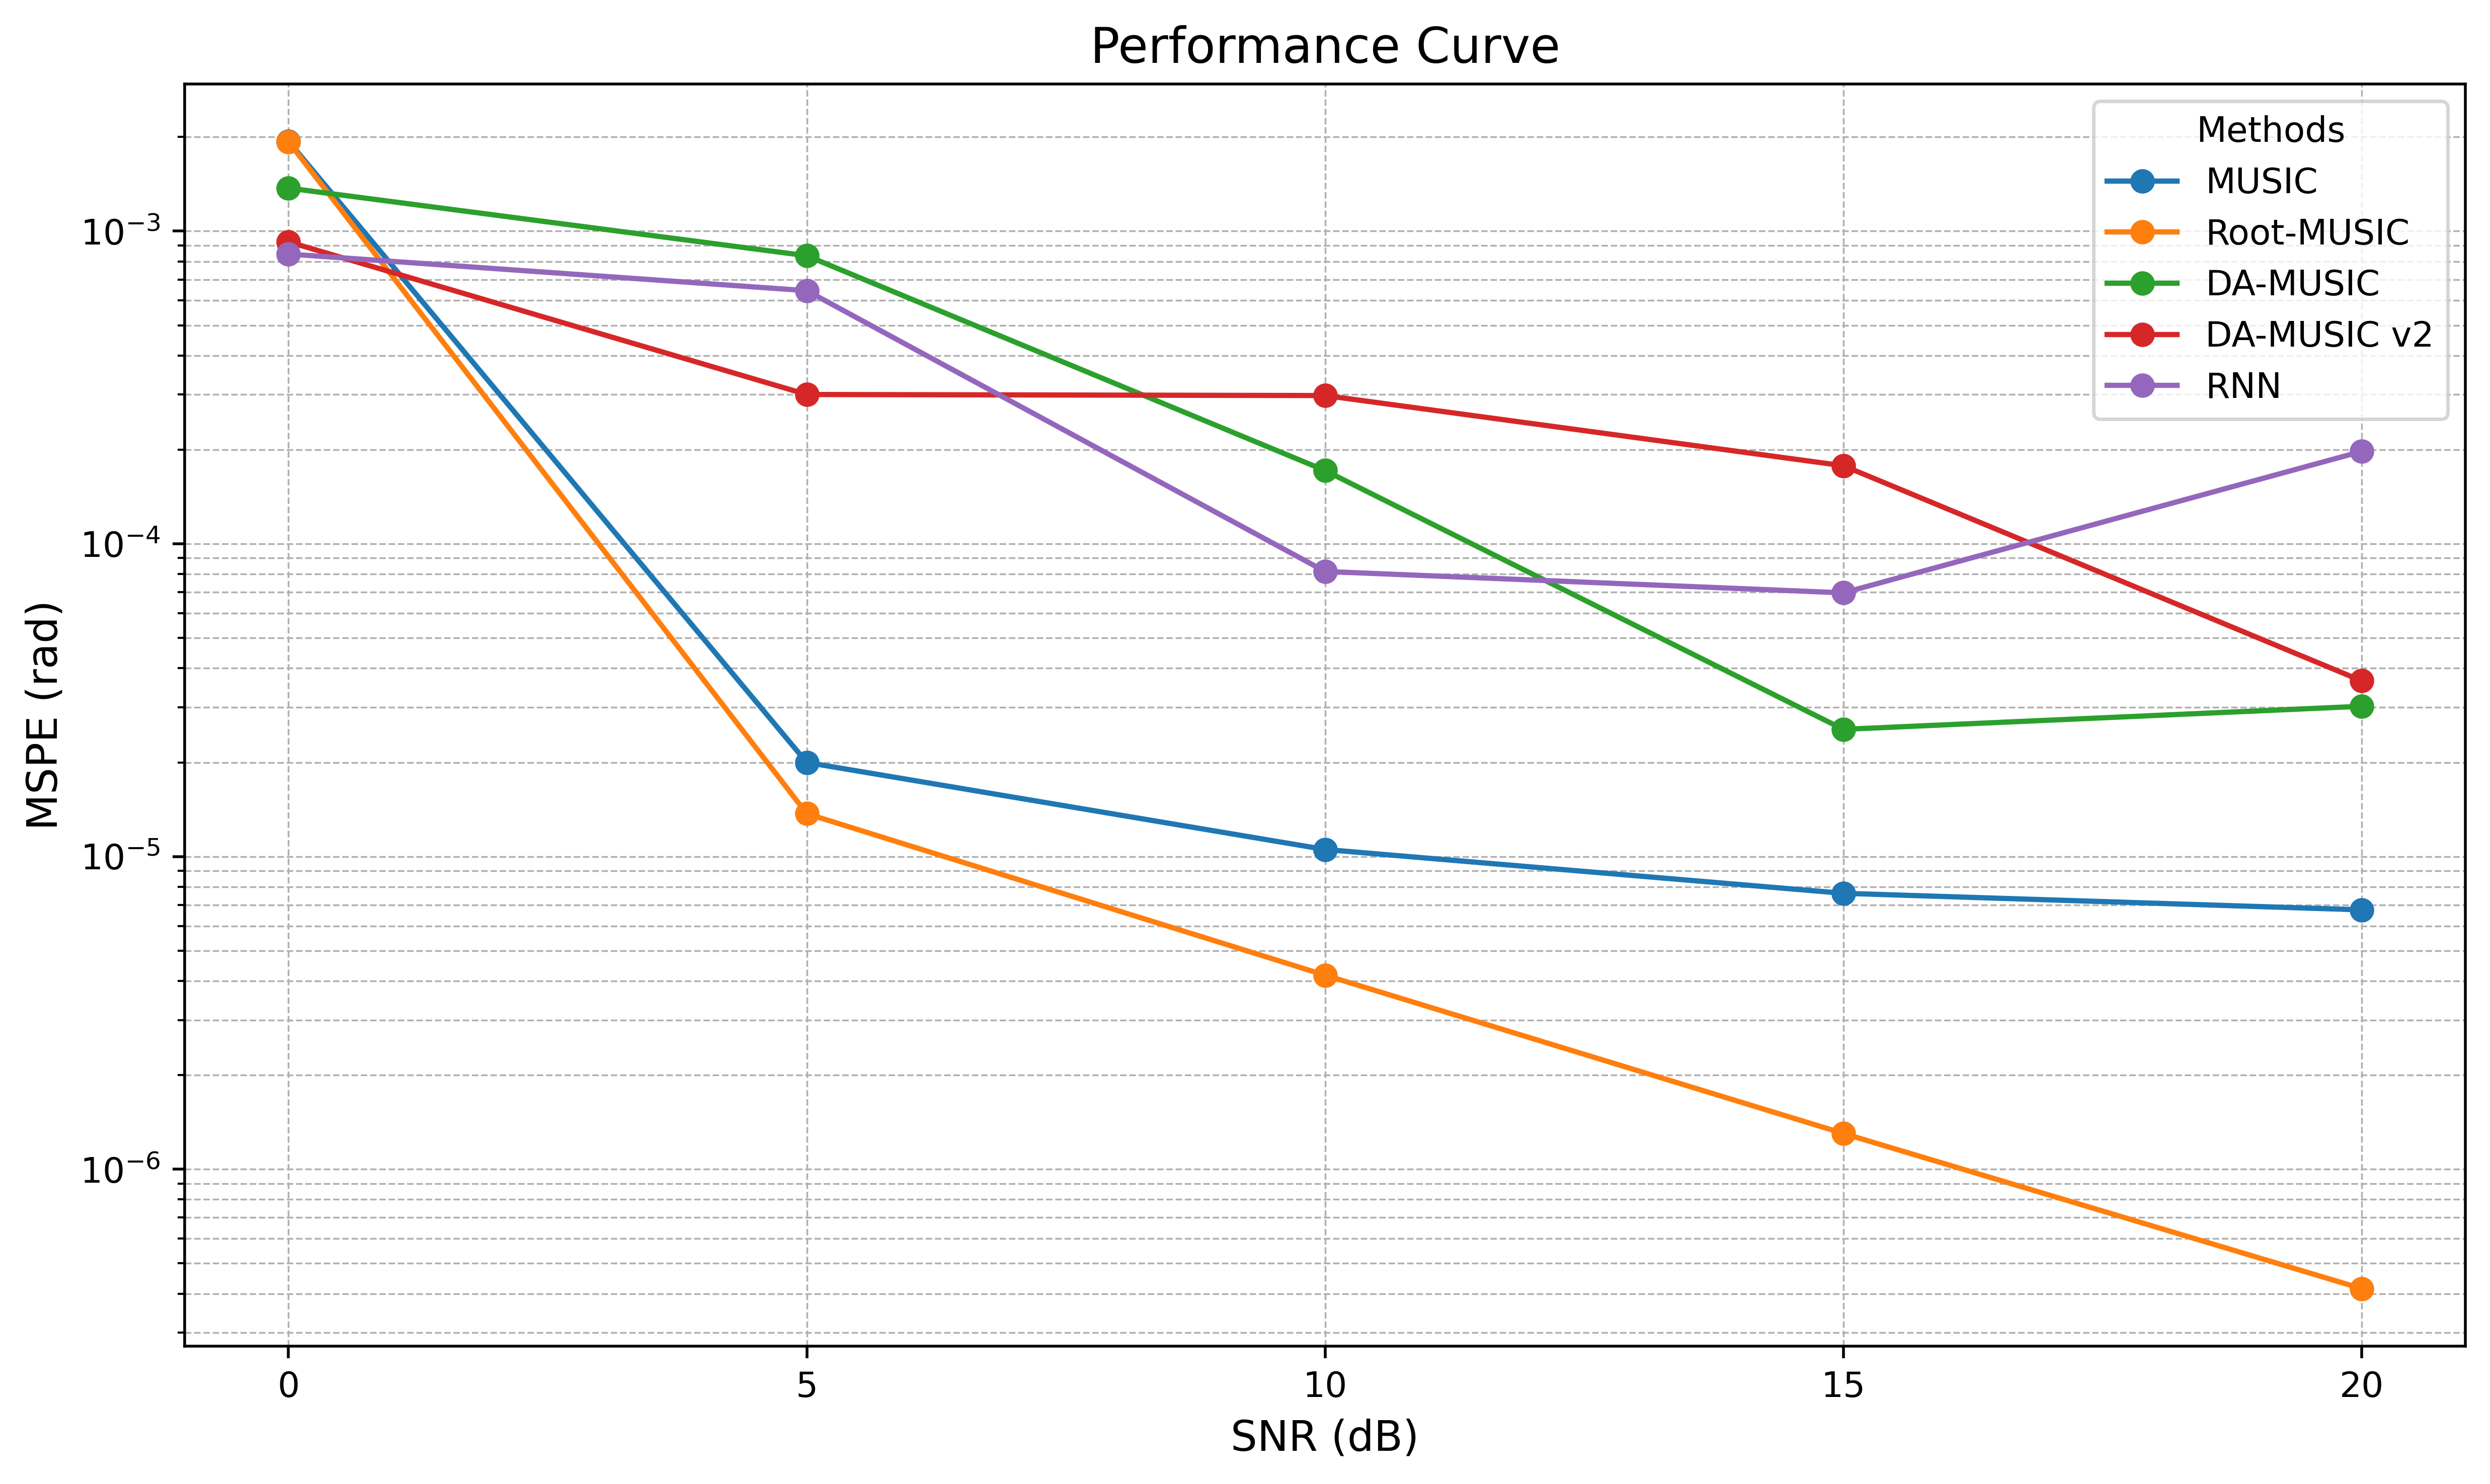

In [27]:
methods = ["MUSIC", 
           "Root-MUSIC",
           "DA-MUSIC", 
           "DA-MUSIC v2", 
           "RNN",
        #    "CRLB"
           ]

plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(SNRs, mean_rmspe[method], marker='o', label=method)

plt.yscale("log")
plt.title("Performance Curve", fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("MSPE (rad)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Methods")
plt.tight_layout()
plt.show()

In [28]:
# fig, axes = plt.subplots(5, 5, figsize=(20, 20)) 

# for i, snr in enumerate(SNRs):
#     for j, name in enumerate(all_rmspe):
#         axes[j, i].hist(all_rmspe[name][i], bins=100, color='blue', edgecolor='black', alpha=0.7, density=True, range=(0, torch.pi/2))
#         axes[j, i].set_xlabel('RMSPE (rad)')
#         axes[j, i].set_ylabel('Density')
#         axes[j, i].set_title(name + ' at ' + str(snr) + 'dB')

# plt.tight_layout()
# plt.show()

In [29]:
# fig, axes = plt.subplots(5, 5, figsize=(20, 20)) 

# for i, snr in enumerate(SNRs):
#     for j, name in enumerate(all_rmspe):
#         axes[j, i].hist(all_rmspe[name][i], bins=100, color='blue', edgecolor='black', alpha=0.7, density=True, range=(0, torch.pi/2), log=True)
#         axes[j, i].set_xlabel('RMSPE (rad)')
#         axes[j, i].set_ylabel('Density')
#         axes[j, i].set_title(name + ' at ' + str(snr) + 'dB')

# plt.tight_layout()
# plt.show()